### 1. Load the Data

In [1]:
import pickle

infile = "data/data_train_new.pkl"
train_data = pickle.load(open(infile, mode='rb'))

In [2]:
train_tokens = train_data.tokens
train_targets = train_data.target

### 2.1 Term-frequency matrix (Word Thresholding)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(preprocessor=lambda word: word,
                                   tokenizer=lambda word: word,
                                   min_df=6,
                                   max_df=0.75)

tf_matrix = count_vectorizer.fit_transform(train_tokens)

### 2.2 Construct a TF-IDF vector-space

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(sublinear_tf=True)
train_tfidf = tfidf_transformer.fit_transform(tf_matrix)

Preview Train in Tf-idf vector space

In [5]:
import pandas as pd

def to_df(tfidf_texts, feature_names):
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(tfidf_texts)]

    df = pd.DataFrame(data=tfidf_texts.toarray(), index=doc_names, columns=feature_names)

    return df

In [6]:
to_df(train_tfidf[:5], count_vectorizer.get_feature_names())

,_kiều,_son,a-series,a-xít,aaa,aag,aami,abass,abbank,abbott,...,ứng_phó,ứng_tuyển,ứng_viên,ứng_xử,ửng,ỷ,‘,’,•,…
Doc0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Doc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Doc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Doc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048369
Doc4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [7]:
train_tfidf.shape

(14891, 16419)

# 3. Tuning SVM parameters on a random subset

In [8]:
train_data_subset = train_data.sample(n=2000, random_state=11)

subset_tokens = train_data_subset.tokens
subset_targets = train_data_subset.target

Construct a pipeline with **CountVectorizer, Tf-idfTransformer & rbfSVC**

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

rbf_svm_pipe = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=lambda word: word,
                                   tokenizer=lambda word: word,
                                   min_df=6,
                                   max_df=0.75)),
    ('tfidf', TfidfTransformer(sublinear_tf = True)),
    ('clf', SVC(kernel='rbf'))
])

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
from scipy.stats import uniform

param_distributions = {"clf__gamma": reciprocal(0.001, 0.1), "clf__C":uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(rbf_svm_pipe, param_distributions, cv=5, n_iter=60, verbose=2)
rnd_search_cv.fit(subset_tokens, subset_targets)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] clf__C=10.671398368691293, clf__gamma=0.0029283044204710972 .....
[CV]  clf__C=10.671398368691293, clf__gamma=0.0029283044204710972, total=   2.7s
[CV] clf__C=10.671398368691293, clf__gamma=0.0029283044204710972 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  clf__C=10.671398368691293, clf__gamma=0.0029283044204710972, total=   2.5s
[CV] clf__C=10.671398368691293, clf__gamma=0.0029283044204710972 .....
[CV]  clf__C=10.671398368691293, clf__gamma=0.0029283044204710972, total=   2.5s
[CV] clf__C=10.671398368691293, clf__gamma=0.0029283044204710972 .....
[CV]  clf__C=10.671398368691293, clf__gamma=0.0029283044204710972, total=   2.5s
[CV] clf__C=10.671398368691293, clf__gamma=0.0029283044204710972 .....
[CV]  clf__C=10.671398368691293, clf__gamma=0.0029283044204710972, total=   2.5s
[CV] clf__C=8.915187114325661, clf__gamma=0.001269910138071481 .......
[CV]  clf__C=8.915187114325661, clf__gamma=0.001269910138071481, total=   3.1s
[CV] clf__C=8.915187114325661, clf__gamma=0.001269910138071481 .......
[CV]  clf__C=8.915187114325661, clf__gamma=0.001269910138071481, total=   3.0s
[CV] clf__C=8.915187114325661, clf__gamma=0.001269910138071481 .......
[CV]  clf__C=8.915187114325661, clf__gamma=0.001269910138071481, total=   3.1s
[CV] clf__C=8

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 23.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=6,
        ngram_range=(1, 1),
        preprocessor=<function <lambda> at...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd240a99d30>, 'clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd240390978>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

best-parameter for gamma

In [11]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

{'clf__C': 7.260514383104393, 'clf__gamma': 0.05178242237668246}
0.9695


In [12]:
best_param = rnd_search_cv.best_params_
best_gamma = best_param['clf__gamma']
best_c = best_param['clf__C']

In [13]:
print(best_gamma)
print(best_c)

0.05178242237668246
7.260514383104393


# 4. Using best parameter to train on full train_data

In [14]:
import time
start_time = time.time()

rbf_svm_clf = SVC(kernel='rbf', gamma=best_gamma, C=best_c)
rbf_svm_clf.fit(train_tfidf, train_targets)

print('===== {} ====='.format(time.time() - start_time))

===== 56.79631996154785 =====


Check the accuracy on Training Data

In [15]:
from sklearn.metrics import accuracy_score
start_time = time.time()

train_preds = rbf_svm_clf.predict(train_tfidf)
print(accuracy_score(train_targets, train_preds))

print('===== {} ====='.format(time.time() - start_time))

0.9910684305956619
===== 48.60628294944763 =====


# 5. TEST

In [16]:
infile = 'data/data_test_new.pkl'
test_data = pickle.load(open(infile, mode='rb'))

test_tokens = test_data.tokens
test_targets = test_data.target

Put the test-set into our "balanced" TF-IDF vector-space

In [17]:
start_time = time.time()

test_tf_matrix = count_vectorizer.transform(test_tokens)
test_tfidf = tfidf_transformer.transform(test_tf_matrix)

print('===== {} ====='.format(time.time() - start_time))

===== 0.48462510108947754 =====


In [18]:
to_df(test_tfidf[:5], count_vectorizer.get_feature_names())

,_kiều,_son,a-series,a-xít,aaa,aag,aami,abass,abbank,abbott,...,ứng_phó,ứng_tuyển,ứng_viên,ứng_xử,ửng,ỷ,‘,’,•,…
Doc0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
test_tfidf.shape

(3723, 16419)

In [20]:
start_time = time.time()

test_preds = rbf_svm_clf.predict(test_tfidf)
print(accuracy_score(test_targets, test_preds))

print('===== {} ====='.format(time.time() - start_time))

0.9769003491807682
===== 10.569866180419922 =====


In [21]:
from scipy.stats import reciprocal
import matplotlib.pyplot as plot
import numpy as np
# fig, ax = plot.subplots(1, 1)

In [22]:
a, b = 0.00623093670105, 1.0062309367
mean, var, skew, kurt = reciprocal.stats(a, b, moments='mvsk')

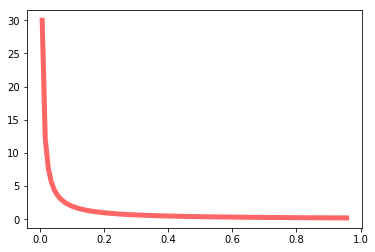

In [23]:
x = np.linspace(reciprocal.ppf(0.01, a, b),
                reciprocal.ppf(0.99, a, b), 100)
plot.plot(x, reciprocal.pdf(x, a, b),
          'r-', lw=5, alpha=0.6, label='reciprocal pdf')

In [24]:
reciprocal.rvs(0.0001, 1, size=100)

array([1.18988899e-03, 1.23747238e-02, 1.93991252e-04, 1.34985222e-01,
       1.70084766e-02, 2.94308300e-04, 4.37937314e-04, 3.02749709e-03,
       7.83640034e-01, 4.23869770e-02, 1.69832401e-04, 4.28137861e-04,
       1.24472942e-02, 6.35422869e-01, 2.56424006e-02, 2.66395200e-04,
       7.18164852e-02, 1.72631162e-03, 4.84425033e-02, 3.40015240e-01,
       5.96802449e-03, 1.12879376e-04, 1.72562217e-01, 9.56063524e-03,
       3.40251956e-01, 1.11520761e-03, 7.25894656e-01, 3.79124982e-04,
       3.55356575e-01, 6.34572751e-01, 6.75014784e-04, 3.43978222e-01,
       1.11848748e-02, 1.15399516e-03, 9.77569319e-04, 3.46937870e-04,
       1.19439312e-02, 6.64123510e-02, 2.82904869e-02, 9.39993822e-03,
       2.48419933e-02, 1.34722526e-01, 2.20644952e-01, 2.74262848e-04,
       2.72886050e-02, 2.98739249e-01, 2.09701818e-02, 3.66785522e-01,
       3.70897156e-03, 7.42735497e-01, 9.00907832e-01, 7.22750421e-01,
       8.93483807e-01, 3.13877104e-02, 4.78066561e-02, 3.21313910e-03,
      